# The Problem

_our ML model is **over fitting** on the data Heance:_  
```we need to reduce/remove the over fitting from our code```

## Solution's  
|sno|Solution|Feasibility|Reason|
|---|--------|-----------|------|
|1.| Adding more data|❌|Limited Data|
|2.| Reducing the complexity of NN Architecture|❌|Already
|3.| Regularization|✅|L2|
|4.| Droupouts|✅|can do|
|5.| Data Augmentation|❌| works well in CNN Acrnhitecture|
|6.| Batch Normalization|✅| can do|
|7.| Early Stopping|❌| apply in future|

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

**Loading and Visualizing the dataset**

In [3]:
df_train = pd.read_csv("fmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("fmnist/fashion-mnist_test.csv")

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


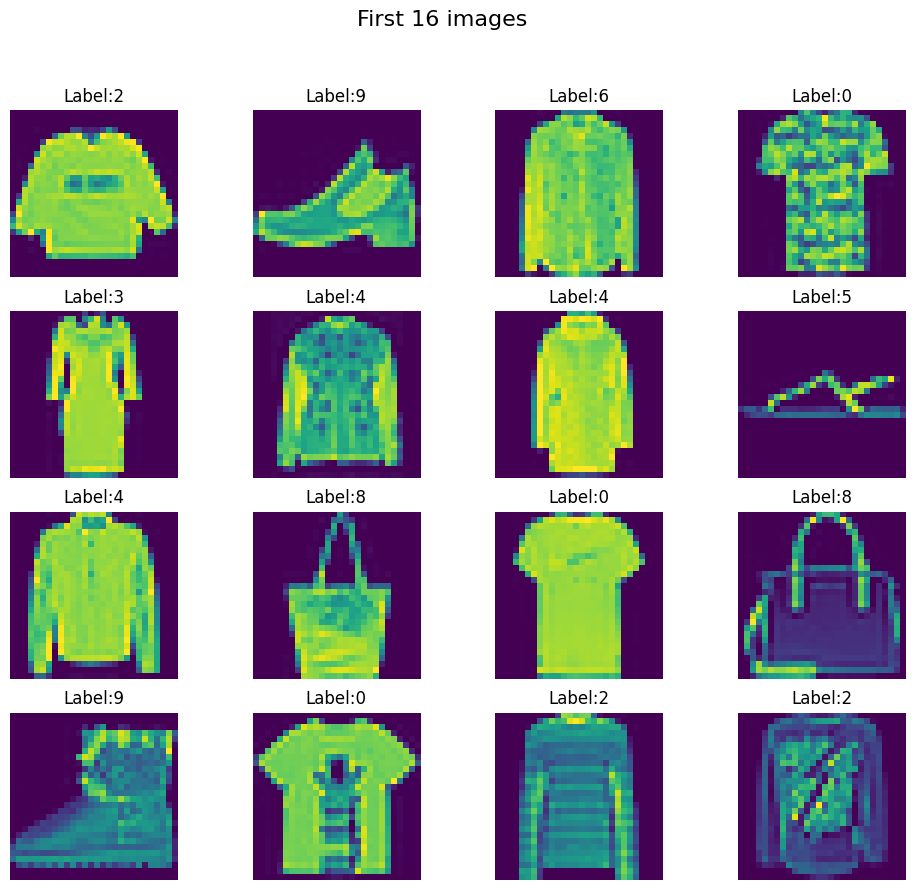

In [4]:
# create a 4x4 grid
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
fig.suptitle("First 16 images", fontsize=16)

# ploting
for i,ax in enumerate(ax.flat):
    img = df_train.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label:{df_train.iloc[i,0]}")

plt.show()

**Spliting data and basic preprocessing**

In [5]:
xtrain = df_train.iloc[:,1:].values
xtest = df_test.iloc[:,1:].values
ytrain=df_train.iloc[:,0].values
ytest=df_test.iloc[:,0].values

print(f"xtrain shape:{xtrain.shape}")
print(f"xtest shape:{xtest.shape}")
print(f"ytrain shape:{ytrain.shape}")
print(f"ytest shape:{ytest.shape}")

xtrain shape:(60000, 784)
xtest shape:(10000, 784)
ytrain shape:(60000,)
ytest shape:(10000,)


In [6]:
pre_xtrain_sample = xtrain[0,400:500]

# scaling the features
xtrain = xtrain / 255.0
xtest = xtest / 255.0

# comparing the result
print(f"before scaling :{pre_xtrain_sample}")
print("-"*100)
print(f"after scalling :{xtrain[0,400:500]}")

before scaling :[221 230 229 221 213 224 233 226 220 219 221 224 223 217 210 218 213 254
   0   0   0 157 226 203 207 211 209 215 205 198 207 208 201 201 197 203
 205 210 207 213 214 214 214 213 208 234 107   0   0 235 213 204 211 210
 209 213 202 197 204 215 217 213 212 210 206 212 203 211 218 215 214 208
 209 222 230   0  52 255 207 200 208 213 210 210 208 207 202 201 209 216
 216 216 216 214 212 205 215 201 228 208]
----------------------------------------------------------------------------------------------------
after scalling :[0.86666667 0.90196078 0.89803922 0.86666667 0.83529412 0.87843137
 0.91372549 0.88627451 0.8627451  0.85882353 0.86666667 0.87843137
 0.8745098  0.85098039 0.82352941 0.85490196 0.83529412 0.99607843
 0.         0.         0.         0.61568627 0.88627451 0.79607843
 0.81176471 0.82745098 0.81960784 0.84313725 0.80392157 0.77647059
 0.81176471 0.81568627 0.78823529 0.78823529 0.77254902 0.79607843
 0.80392157 0.82352941 0.81176471 0.83529412 0.83921569 0.

**Check GPU Availibility**

In [7]:
print(f"Is CUDA available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Capability: {torch.cuda.get_device_capability(0)}")
    print(f"PyTorch Version: {torch.__version__}")

Is CUDA available? True
Current device: NVIDIA GeForce GTX 1650
CUDA Capability: (7, 5)
PyTorch Version: 2.9.1+cu128


In [8]:
"""
before starting check if the GPU is available, select it; otherwise use cpu
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device :{device}")

using device :cuda


**Creating CustomDataset Class**

In [9]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [10]:
# creating train and test dataset object
train_dataset = CustomDataset(xtrain, ytrain)
test_dataset = CustomDataset(xtest, ytest)

**Enable LoadData Pinning and increase the batchsize**

In [11]:
# Creating train test loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,pin_memory=True)

**Building ANN class**

# Droupout  
1. Applied to the hidden layer
2. Applied after the RELU activation function
3. Randomly turn off p% neurons in the hidden layer during each forward pass
4. This has a regualization effect
5. During evaluation droupout is not used

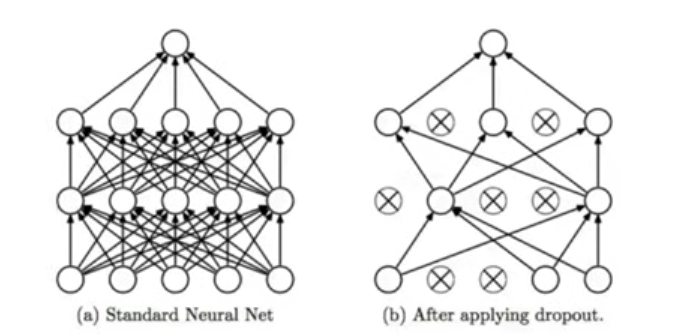

In [12]:
class myNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.model(x)

# Batch Norm  
define : _Batch Normalization (BN) in data science is a technique for deep learning that stabilizes and speeds up training by normalizing layer inputs within mini-batches, reducing "internal covariate shift" (changing input distributions) and allowing higher learning rates, which helps prevent vanishing/exploding gradients and improves model accuracy_

* **Applied to hidden layers:**
  * Typically applied to the hidden layer of the neural network but not to the output lay

* **Applied after the linear layer and before activation function**
  * normalise the output of the proceeding layer **(eg: nn.Linear)** and it usually followed by a activation function (eg **ReLU**)
* **Normalize activation**
  * computer mean and variance of a activation within a mini batch and use this statistics to normalise the activation
* **Includes learnable peramaters**
  * introduce to learn about parameter **Gamma (slicing)** and **beta (shifting)**, which allow the network to adjust the normalised outputs. 
* **Improve traning stability**
  * Reduce the internal covariance shift, stabilize the traning process and allow the user for Higher Learning rate.
* **Regularization effect**
  * Introduce some regularization because the statistics are compute over a mini batch, adding noise to the traning processes
* **constant during evaluation**
  * during evaluation Mini batch normalisation use the accumulated mean and variance rather than recalculating it from the Mini batches


In [14]:
class myNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.model(x)

**set Learning_rate and epoch**

In [15]:
epochs = 100
Learning_rate = 0.001

**Instatite the model and Move it to GPU**

In [16]:
model = myNN(xtrain.shape[1])
model = model.to(device)

**Define Lossfunction**

In [17]:
Lossfunction = nn.CrossEntropyLoss()

**Define Optimizer**

# regularization  
Define :_L2 regularization (Ridge Regression) in machine learning prevents overfitting by adding a penalty term to the model's loss function, specifically the squared magnitude of all weights, which shrinks coefficients towards zero without making them exactly zero_

In [18]:
optimzer = optim.Adam(model.parameters(), lr = Learning_rate, weight_decay=1e-4)

**Training Loop (optimize to work in gpu)**

In [19]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_label in train_loader:

        # moving data to gpu
        batch_features, batch_label = batch_features.to(device), batch_label.to(device)
        
        # forword pass
        outputs = model(batch_features)
        
        # calcluate loss
        loss = Lossfunction(outputs, batch_label)
        
        # back prop
        optimzer.zero_grad()
        loss.backward()
        
        # upgrade grads
        optimzer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    # priniting the avrage loss per epoch
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch+1} , Loss: {avg_loss} , total_epoch_loss:{total_epoch_loss}" )

Epoch: 1 , Loss: 0.6427962406357722 , total_epoch_loss:301.4714368581772
Epoch: 2 , Loss: 0.44694316781151777 , total_epoch_loss:209.61634570360184
Epoch: 3 , Loss: 0.40839356720955894 , total_epoch_loss:191.53658302128315
Epoch: 4 , Loss: 0.3858256989450597 , total_epoch_loss:180.952252805233
Epoch: 5 , Loss: 0.36710703979804316 , total_epoch_loss:172.17320166528225
Epoch: 6 , Loss: 0.3570490785435573 , total_epoch_loss:167.45601783692837
Epoch: 7 , Loss: 0.3459857950713843 , total_epoch_loss:162.26733788847923
Epoch: 8 , Loss: 0.33396606700125536 , total_epoch_loss:156.63008542358875
Epoch: 9 , Loss: 0.3293705301752477 , total_epoch_loss:154.47477865219116
Epoch: 10 , Loss: 0.3225230458957046 , total_epoch_loss:151.26330852508545
Epoch: 11 , Loss: 0.31912107028559583 , total_epoch_loss:149.66778196394444
Epoch: 12 , Loss: 0.30979785326320225 , total_epoch_loss:145.29519318044186
Epoch: 13 , Loss: 0.30291390584221783 , total_epoch_loss:142.06662184000015
Epoch: 14 , Loss: 0.3028361927

**set model to eval mode**

In [20]:
model.eval()

myNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

**GPU Evaluation Code**

In [21]:
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:

        # moving data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        output = model(batch_features)
        _, predicted = torch.max(output,1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8933


**Checking Accuracy for traning data**

In [22]:
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in train_loader:

        # moving data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        output = model(batch_features)
        _, predicted = torch.max(output,1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9486
